(**Click the icon below to open this notebook in Colab**)
[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week03/notebook/demo.ipynb)

In [2]:
%%sh

which python

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/bin/python


# Load the MNIST data

We will take the built-in hand-written digits dataset in `scikit-learn` as an example. This is a copy of the test set of the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Each datapoint is a 8x8 image of a digit.

| Attribute           | Value         |
|---------------------|---------------|
| Classes             | 10            |
| Samples per class   | ~180          |
| Samples total       | 1797          |
| Dimensionality      | 64            |
| Features            | integers 0-16 |


In [1]:
from sklearn import datasets

digits = datasets.load_digits()

In [3]:
data = digits.data # the input X
target = digits.target # the output Y
feature_names = digits.feature_names
target_names = digits.target_names

In [4]:
print(f"The shape of the data is {data.shape}")
print(f"The shape of the target is {target.shape}")
print(f"First 5 feature names are {feature_names[:5]}")
print(f"Target names are {target_names}")

The shape of the data is (1797, 64)
The shape of the target is (1797,)
First 5 feature names are ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4']
Target names are [0 1 2 3 4 5 6 7 8 9]


In [5]:
target[:5]

array([0, 1, 2, 3, 4])

# Visualize the MNIST digits

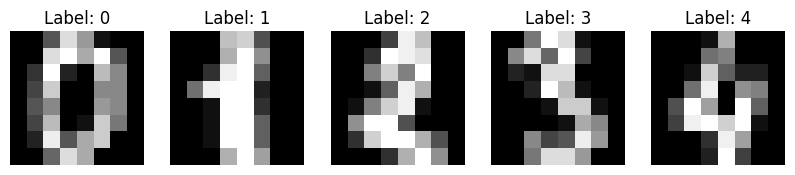

In [6]:
# visualize the first 5 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(data[i].reshape(8, 8), cmap='gray')
    ax[i].set_title(f"Label: {target[i]}")
    ax[i].axis('off')

# The format of the model output
The output of the algorithm could be
- Option 1: The actual digits [0,9]
- Option 2: The one-hot encoded vecor
    - Example: number 1 will be represented as [0,1,0,0,0,0,0,0,0,0]
 
If we go with option 2, here are dimensions of data we are dealing with
- Input shape: 1797 x 64
- Output shape: 1797 x 10

# The loss function

We use the cross-entropy loss function for this classification problem. 

## Single Data Point
For a single data point, the categorical cross-entropy loss function is defined as:

$$
\begin{aligned}
L = -\sum_{j=1}^{C}y_j log(p_j)
\end{aligned}
$$

Where:
* $C$ is the number of classes
* $y_i$ is the true label (a one-hot encoded vector, where $y_i=1$ for the correct class and $y_i=0$ for the incorrect classes)
* $p_i$ is the predicted probability for class $i$ (output of the softmax function)

## Multiple Data Points

For a batch of N data points, the loss function is defined as the average over the whole batch:

$$
\begin{aligned}
L = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ij} log(p_{ij})
\end{aligned}
$$

## Implement the cross-entropy loss function with `numpy`

In [7]:
import numpy as np

# Implement the single-sample version of the loss function
def cross_entropy_loss_single(y_true, y_pred):
    # Clip the predicted values to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Calculate the cross-entropy loss for a single sample
    loss = -np.sum(y_true * np.log(y_pred))
    return loss

In [8]:
# Example: test the single-sample loss function
y_true = np.array([0,1,0])
y_pred_1 = np.array([0.,0.99,0.01])
y_pred_2 = np.array([0.2,0.7,0.1])
y_pred_3 = np.array([0.7,0.2,0.1])
y_pred_4 = np.array([0.33,0.33,0.34])
loss_1 = cross_entropy_loss_single(y_true,y_pred_1)
loss_2 = cross_entropy_loss_single(y_true,y_pred_2)
loss_3 = cross_entropy_loss_single(y_true,y_pred_3)
loss_4 = cross_entropy_loss_single(y_true,y_pred_4)
print(f"Loss 1: {loss_1}")
print(f"Loss 2: {loss_2}")
print(f"Loss 3: {loss_3}")
print(f"Loss 4: {loss_4}")

Loss 1: 0.01005033585350145
Loss 2: 0.35667494393873245
Loss 3: 1.6094379124341003
Loss 4: 1.1086626245216111


In [9]:
# Implement the multi-sample version of the loss function
def cross_entropy_loss_multi(y_true, y_pred):
    # Calculate the number of samples in the batch
    num_samples = y_true.shape[0]
    # Calculate the cross-entropy loss for each sample
    losses = -np.sum(y_true * np.log(y_pred), axis=1)
    # Calculate the average loss across all samples
    loss = np.sum(losses) / num_samples
    return loss

In [10]:
# Example: test the multi-sample loss function
## Generate 
y_true = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
y_pred = np.random.random(size=(3, 3))
y_pred = y_pred / y_pred.sum(axis=1, keepdims=True)
loss = cross_entropy_loss_multi(y_true, y_pred)
print(y_true)
print(y_pred)
print(y_pred.sum(axis=1)) # validate if the total is 1
print(f"Loss = {loss}")

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[0.58544872 0.10647212 0.30807916]
 [0.10495975 0.15775603 0.73728422]
 [0.11822677 0.45973382 0.42203941]]
[1. 1. 1.]
Loss = 1.0815796007689922


# The gradient function
**Q**: What would be the corresponding gradient of the cross entropy function we defined earlier?

**A**: It depends on the actual prediction model ...

## Softmax function

The softmax function transforms a vector of real numbers into a vector of probabilities, such that the elements of the output vector are in the range (0, 1) and sum to 1. The softmax function is defined as:

$$
\begin{aligned}
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}
\end{aligned}
$$

Where:
- $z_i$ is the ith element of the input vector
- $C$ is the number of elements (classes) in the input vector
- The exponential function in the formula above ensures the obtained values are non-negative.
- The normalization term in the denominator ensures that the sum of the obtained values from the softmax function sum to 1 and the individual values always lie between 0 and 1.


In [11]:
def softmax(z):
    exp_z = np.exp(z)
    # Subtract max for numerical stability to avoid overflow
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [12]:
z = np.array([
    [1, 2, 3],
    [4, 1, 2]
])
probabilities = softmax(z)
print(probabilities)

[[0.09003057 0.24472847 0.66524096]
 [0.84379473 0.04201007 0.1141952 ]]


In [13]:
np.sum(probabilities, axis=1, keepdims=True)

array([[1.],
       [1.]])

## The gradient of the loss function

We know that the cross entropy loss function for multiple data points can be expressed as
$$
\begin{aligned}
L = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ij} log(p_{ij})
\end{aligned}
$$

Where 
- $y_{ij}$ is the ground truth label of the $i^{th}$ data point being of class $j$.
- $p_{ij}$ is the probability of the $i^{th}$ data point being of class $j$.

Assume $p_{ij}$ can be expressed in the form of a softmax function of an input vector $z_{ij}$:
$$
\begin{aligned}
p_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{C}e^{z_{ik}}}
\end{aligned}
$$

The loss function could then be rewritten as 
$$
\begin{aligned}
L = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ij} log(\frac{e^{z_{ij}}}{\sum_{k=1}^{C}e^{z_{ik}}}) = \frac{1}{N}\sum_{i=1}^{N}L_i
\end{aligned}
$$

Where 
$$
\begin{aligned}
L_i = - \sum_{j=1}^{C}y_{ij} log(p_{ij}) = - \sum_{j=1}^{C}y_{ij} log(\frac{e^{z_{ij}}}{\sum_{k=1}^{C}e^{z_{ik}}})
\end{aligned}
$$

In order to calculate the gradient function, we could take the following steps:
### Step 1: Compute $\frac{\partial L_i}{\partial z_{il}}$
$$
\begin{aligned}
\frac{\partial L_i}{\partial z_{il}} = - \sum_{j=1}^{C}y_{ij} \frac{\partial log(p_{ij})}{\partial z_{il}} 
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial log(p_{ij})}{\partial z_{il}} =  \frac{\partial (z_{ij} - log(\sum_{k=1}^{C}e^{z_{ik}}))}{\partial z_{il}} = \delta_{jl} - \frac{e^{z_{il}}}{\sum_{k=1}^{C}e^{z_{ik}}} = \delta_{jl} - p_{il}
\end{aligned}
$$

Therefore,
$$
\begin{aligned}
\frac{\partial L_i}{\partial z_{il}} = - \sum_{j=1}^{C}y_{ij} \frac{\partial log(p_{ij})}{\partial z_{il}} = - \sum_{j=1}^{C}y_{ij} (\delta_{jl} - p_{il}) = -(y_{il} - p_{il} \sum_{j=1}^{C}y_{ij}) = p_{il} - y_{il}
\end{aligned}
$$

### Step 2: Gradient for the batch with regard to the input vector $Z$
$$
\begin{aligned}
\frac{\partial L}{\partial z_{ij}} = \frac{1}{N} (p_{il} - y_{il})
\end{aligned}
$$

If we rewrite the formula in matrix form, we could get:
$$
\begin{aligned}
\frac{\partial L}{\partial Z} = \frac{1}{N} (P - Y)
\end{aligned}
$$

Where:
- $Z$ is an input matrix (shape $(N, C)$)
- $P$ is a matrix of predicted probabilities (shape $(N, C)$)
- $Y$ is a one-hot encoded matrix of ground truth labels (shape $(N, C)$)

### Step 3: Gradient for the batch with regard to the weight matrix $\theta$

Assume the following relation between $X$ and $Z$:
$$
\begin{aligned}
Z = X \cdot \theta
\end{aligned}
$$

Where:
- $X$ is the input training data matrix (shape $(N, D)$), where $D$ is the number of features
- $\theta$ is the weight matrix (shape $(D, C)$)

According to the chain rule, we could calculate the gradient of the loss function with regard to $\theta$ as follows:
$$
\begin{aligned}
\frac{\partial L}{\partial \theta} = \frac{\partial L}{\partial Z} \cdot \frac{\partial Z}{\partial \theta} = \frac{1}{N} X^T \cdot (P - Y)
\end{aligned}
$$



# Put all together

In order to train a multi-class classification model, we need to repeat the following steps until the model converges or until the maximum number of iterations (also known as `epochs`) is reached:
- Iterate over the training data $X_{N \times D}$, $y_{N \times C}$
- Update the parameters $\theta = \theta - \frac{\alpha}{N} X^T \cdot (P - Y)$

In [15]:
# Let's look at the data we have again
print(f"The shape of the data is {data.shape}")
print(f"The shape of the target is {target.shape}")
print(f"First 5 samples of the target are {target[:5]}")
print(f"Target names are {target_names}")


The shape of the data is (1797, 64)
The shape of the target is (1797,)
First 5 samples of the target are [0 1 2 3 4]
Target names are [0 1 2 3 4 5 6 7 8 9]


## Now we have a problem
The shape of the target is of shape (N,) not (N, C)!!!
- Specifically, we need the target $Y$ to be of shape $(1797, 10)$

In [16]:
# We need to do one-hot encoding for each target label

N = data.shape[0]
C = len(target_names)
print(f"N: {N}, C: {C}")

N: 1797, C: 10


In [17]:
Y = np.zeros((N, C))
Y[np.arange(N), target] = 1

In [18]:
Y[:3]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
target[:3]

array([0, 1, 2])

## Let's implement the algorithm

In [20]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

N = digits.data.shape[0]
C = len(digits.target_names)
X = data
Y = np.zeros((N, C))
Y[np.arange(N), digits.target] = 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

epochs = 100
alpha = 0.0001
def train(X, Y, alpha, epochs):
    D, C = X.shape[1], Y.shape[1]
    theta = np.random.randn(D, C)
    for epoch in range(epochs):
        Z = X.dot(theta)
        P = softmax(Z)
        loss = cross_entropy_loss_multi(Y, P)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")
        theta = theta - alpha * X.T.dot(P - Y)
    return theta

theta = train(X_train, Y_train, alpha, epochs)


Epoch 0: Loss = 60.566761553085776
Epoch 10: Loss = 10.957079130784745
Epoch 20: Loss = 4.073395896554243
Epoch 30: Loss = 2.6622148037966116
Epoch 40: Loss = 1.9901399990076862
Epoch 50: Loss = 1.6523905417468232
Epoch 60: Loss = 1.3407614744731022
Epoch 70: Loss = 1.1322092677026916
Epoch 80: Loss = 0.996374294120693
Epoch 90: Loss = 0.8945413101988137


## Let's make some predictions

In [21]:
def predict(X, theta):
    P = softmax(X @ theta)
    # Convert the one-hot encoded predictions to a single integer
    return np.argmax(P, axis=1)

In [22]:
y_pred = predict(X_test, theta)

In [23]:
y_pred[:10]

array([6, 9, 3, 7, 6, 2, 5, 2, 5, 2])

In [24]:
y_test = np.argmax(Y_test, axis=1)
y_test[:10]

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2])

In [25]:
# Measure the accuracy of the model we just built
accuracy = np.mean(y_test == y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8916666666666667


### Let's clean up the code a bit

# Let's try a pre-built model

[[Source](https://scikit-learn.org/1.5/auto_examples/classification/plot_digits_classification.html)]

In [26]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the MNIST digits dataset
digits = datasets.load_digits()

# Prepare the data
X = digits.data  # Features (8x8 pixel images flattened into 64-dimensional vectors)
y = digits.target  # Labels (digits from 0 to 9)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
# Set multi_class='multinomial' for multi-class classification
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.50%


/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
